In [1]:
# Cell 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

print("Libraries imported successfully!")



Libraries imported successfully!


In [ ]:
# Cell 2: Data Loading and Initial Exploration
# Note: Download the dataset from Kaggle and place the files in your working directory
# The dataset typically contains train.txt, test.txt, and val.txt files

def load_emotion_data(file_path):
    """
    Load emotion dataset from text file
    Expected format: text;emotion
    """
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            if ';' in line:
                text, emotion = line.strip().split(';')
                data.append({'text': text, 'emotion': emotion})
    return pd.DataFrame(data)




# Load the datasets (you'll need to download these from Kaggle)
try:
    train_df = load_emotion_data('Dataset/train.txt')
    test_df = load_emotion_data('Dataset/test.txt')
    val_df = load_emotion_data('Dataset/val.txt')

    print(f"Train dataset shape: {train_df.shape}")
    print(f"Test dataset shape: {test_df.shape}")
    print(f"Validation dataset shape: {val_df.shape}")

    # Display first few rows
    print("\nFirst 5 training examples:")
    print(train_df.head())

    # Check emotion distribution
    print("\nEmotion distribution in training data:")
    print(train_df['emotion'].value_counts())

except FileNotFoundError:
    print("Dataset files not found. Please download from Kaggle and place in working directory.")
    # Create sample data for demonstration
    sample_data = {
        'text': [
            'I am so happy today!',
            'This makes me really angry',
            'I feel so sad about this',
            'This is absolutely wonderful',
            'I am scared of what might happen',
            'I love spending time with family'
        ],
        'emotion': ['joy', 'anger', 'sadness', 'joy', 'fear', 'love']
    }
    train_df = pd.DataFrame(sample_data)
    test_df = train_df.copy()
    val_df = train_df.copy()
    print("Using sample data for demonstration")



Train dataset shape: (16000, 2)
Test dataset shape: (2000, 2)
Validation dataset shape: (2000, 2)

First 5 training examples:
                                                text  emotion
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger

Emotion distribution in training data:
emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64


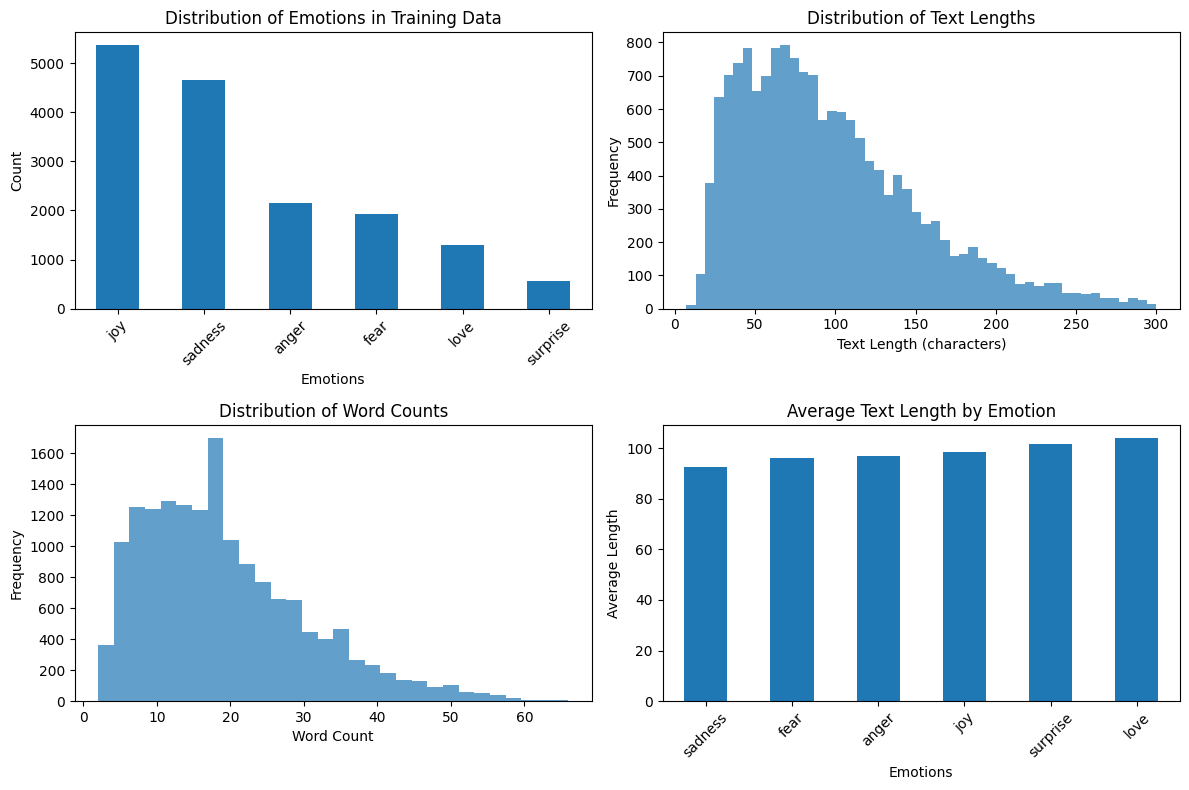

In [4]:
# Cell 3: Exploratory Data Analysis
plt.figure(figsize=(12, 8))

# Emotion distribution
plt.subplot(2, 2, 1)
train_df['emotion'].value_counts().plot(kind='bar')
plt.title('Distribution of Emotions in Training Data')
plt.xlabel('Emotions')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Text length distribution
plt.subplot(2, 2, 2)
train_df['text_length'] = train_df['text'].apply(len)
plt.hist(train_df['text_length'], bins=50, alpha=0.7)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')

# Word count distribution
plt.subplot(2, 2, 3)
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
plt.hist(train_df['word_count'], bins=30, alpha=0.7)
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

# Average text length by emotion
plt.subplot(2, 2, 4)
emotion_length = train_df.groupby('emotion')['text_length'].mean().sort_values()
emotion_length.plot(kind='bar')
plt.title('Average Text Length by Emotion')
plt.xlabel('Emotions')
plt.ylabel('Average Length')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [5]:
# Cell 4: Text Preprocessing
class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        """Clean and preprocess text"""
        # Convert to lowercase
        text = text.lower()

        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Remove extra whitespaces
        text = ' '.join(text.split())

        return text

    def preprocess_text(self, text):
        """Complete preprocessing pipeline"""
        # Clean text
        text = self.clean_text(text)

        # Tokenize
        tokens = word_tokenize(text)

        # Remove stopwords and lemmatize
        tokens = [self.lemmatizer.lemmatize(token)
                 for token in tokens if token not in self.stop_words]

        return ' '.join(tokens)

    def preprocess_dataframe(self, df):
        """Apply preprocessing to entire dataframe"""
        df_processed = df.copy()
        df_processed['processed_text'] = df_processed['text'].apply(self.preprocess_text)
        return df_processed

# Initialize preprocessor and apply to datasets
preprocessor = TextPreprocessor()

print("Preprocessing datasets...")
train_processed = preprocessor.preprocess_dataframe(train_df)
test_processed = preprocessor.preprocess_dataframe(test_df)
val_processed = preprocessor.preprocess_dataframe(val_df)

print("Before preprocessing:")
print(train_df['text'].iloc[0])
print("\nAfter preprocessing:")
print(train_processed['processed_text'].iloc[0])

Preprocessing datasets...
Before preprocessing:
i didnt feel humiliated

After preprocessing:
didnt feel humiliated


In [6]:
# Cell 5: Feature Engineering
# Combine all datasets for consistent vocabulary
all_data = pd.concat([train_processed, val_processed, test_processed], ignore_index=True)

# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,  # Limit vocabulary size
    ngram_range=(1, 2),  # Use unigrams and bigrams
    min_df=1,           # Ignore terms that appear in less than 2 documents
    max_df=1.0         # Ignore terms that appear in more than 95% of documents
)

# Fit on all data and transform training data
print("Creating TF-IDF features...")
X_train_tfidf = tfidf_vectorizer.fit_transform(train_processed['processed_text'])
X_val_tfidf = tfidf_vectorizer.transform(val_processed['processed_text'])
X_test_tfidf = tfidf_vectorizer.transform(test_processed['processed_text'])

y_train = train_processed['emotion']
y_val = val_processed['emotion']
y_test = test_processed['emotion']

print(f"Training features shape: {X_train_tfidf.shape}")
print(f"Validation features shape: {X_val_tfidf.shape}")
print(f"Test features shape: {X_test_tfidf.shape}")


Creating TF-IDF features...
Training features shape: (16000, 10000)
Validation features shape: (2000, 10000)
Test features shape: (2000, 10000)


In [7]:
# Cell 6: Model Training and Comparison
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'SVM': SVC(kernel='linear', random_state=42, probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate models
model_results = {}

print("Training models...")
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train model
    model.fit(X_train_tfidf, y_train)

    # Make predictions
    train_pred = model.predict(X_train_tfidf)
    val_pred = model.predict(X_val_tfidf)

    # Calculate accuracies
    train_acc = accuracy_score(y_train, train_pred)
    val_acc = accuracy_score(y_val, val_pred)

    model_results[name] = {
        'model': model,
        'train_accuracy': train_acc,
        'val_accuracy': val_acc,
        'val_predictions': val_pred
    }

    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")

Training models...

Training Logistic Regression...
Training Accuracy: 0.9557
Validation Accuracy: 0.8860

Training Naive Bayes...
Training Accuracy: 0.8387
Validation Accuracy: 0.7565

Training SVM...
Training Accuracy: 0.9686
Validation Accuracy: 0.9045

Training Random Forest...
Training Accuracy: 0.9976
Validation Accuracy: 0.8955



Model Performance Comparison:
                 Model  Training Accuracy  Validation Accuracy
0  Logistic Regression           0.955750               0.8860
1          Naive Bayes           0.838750               0.7565
2                  SVM           0.968625               0.9045
3        Random Forest           0.997625               0.8955

Best Model: SVM
Best Validation Accuracy: 0.9045


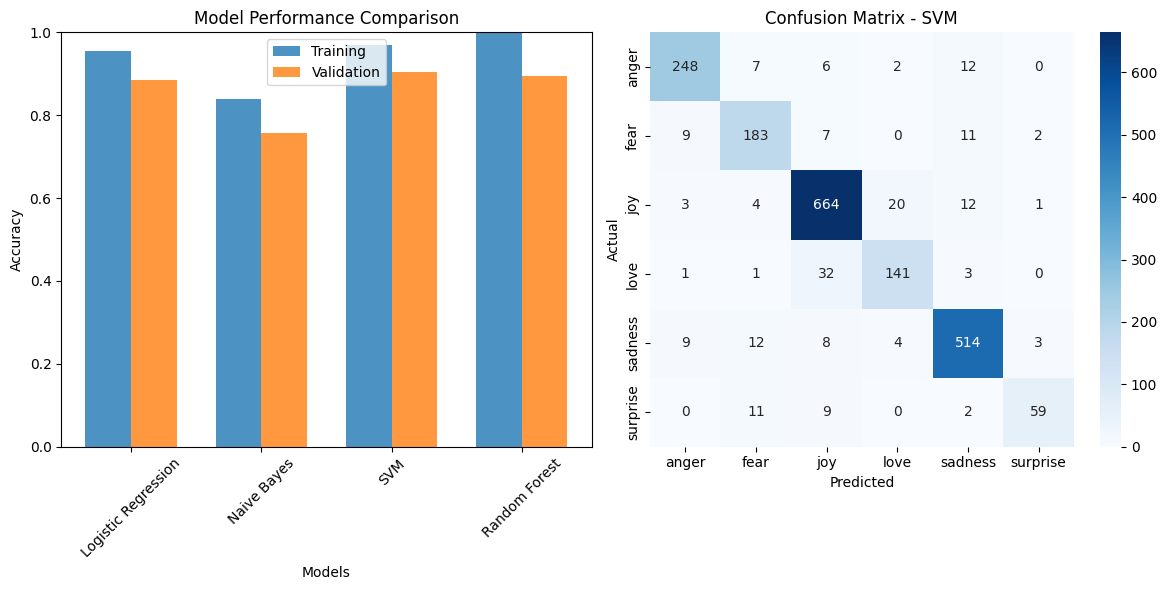

In [8]:
# Cell 7: Model Evaluation and Visualization
# Compare model performance
results_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Training Accuracy': [results['train_accuracy'] for results in model_results.values()],
    'Validation Accuracy': [results['val_accuracy'] for results in model_results.values()]
})

print("\nModel Performance Comparison:")
print(results_df)

# Visualize model comparison
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
x = np.arange(len(results_df))
width = 0.35

plt.bar(x - width/2, results_df['Training Accuracy'], width, label='Training', alpha=0.8)
plt.bar(x + width/2, results_df['Validation Accuracy'], width, label='Validation', alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Performance Comparison')
plt.xticks(x, results_df['Model'], rotation=45)
plt.legend()
plt.ylim(0, 1)

# Select best model (highest validation accuracy)
best_model_name = max(model_results.keys(),
                     key=lambda x: model_results[x]['val_accuracy'])
best_model = model_results[best_model_name]['model']

print(f"\nBest Model: {best_model_name}")
print(f"Best Validation Accuracy: {model_results[best_model_name]['val_accuracy']:.4f}")

# Confusion Matrix for best model
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_val, model_results[best_model_name]['val_predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

In [9]:
# Cell 8: Detailed Evaluation
# Classification report for best model
print(f"\nDetailed Classification Report - {best_model_name}:")
print(classification_report(y_val, model_results[best_model_name]['val_predictions']))

# Test set evaluation
test_pred = best_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, test_pred)

print(f"\nFinal Test Set Accuracy: {test_accuracy:.4f}")
print("\nTest Set Classification Report:")
print(classification_report(y_test, test_pred))



Detailed Classification Report - SVM:
              precision    recall  f1-score   support

       anger       0.92      0.90      0.91       275
        fear       0.84      0.86      0.85       212
         joy       0.91      0.94      0.93       704
        love       0.84      0.79      0.82       178
     sadness       0.93      0.93      0.93       550
    surprise       0.91      0.73      0.81        81

    accuracy                           0.90      2000
   macro avg       0.89      0.86      0.87      2000
weighted avg       0.90      0.90      0.90      2000


Final Test Set Accuracy: 0.8990

Test Set Classification Report:
              precision    recall  f1-score   support

       anger       0.91      0.92      0.91       275
        fear       0.87      0.86      0.87       224
         joy       0.90      0.94      0.92       695
        love       0.81      0.75      0.78       159
     sadness       0.94      0.93      0.93       581
    surprise       0.80    

In [10]:
# Cell 9: Feature Importance Analysis (for interpretable models)
if best_model_name in ['Logistic Regression', 'Random Forest']:
    print(f"\nFeature Importance Analysis for {best_model_name}:")

    feature_names = tfidf_vectorizer.get_feature_names_out()

    if best_model_name == 'Logistic Regression':
        # For multiclass logistic regression, get coefficients for each class
        emotions = best_model.classes_

        for i, emotion in enumerate(emotions):
            coefficients = best_model.coef_[i]
            top_features_idx = np.argsort(np.abs(coefficients))[-10:]

            print(f"\nTop 10 features for {emotion}:")
            for idx in reversed(top_features_idx):
                print(f"  {feature_names[idx]}: {coefficients[idx]:.4f}")

    elif best_model_name == 'Random Forest':
        # Get feature importances
        importances = best_model.feature_importances_
        top_features_idx = np.argsort(importances)[-20:]

        print("\nTop 20 most important features:")
        for idx in reversed(top_features_idx):
            print(f"  {feature_names[idx]}: {importances[idx]:.4f}")


In [11]:
# Cell 10: Prediction Function and Demo
class EmotionDetector:
    def __init__(self, model, vectorizer, preprocessor):
        self.model = model
        self.vectorizer = vectorizer
        self.preprocessor = preprocessor

    def predict_emotion(self, text):
        """Predict emotion for a single text"""
        # Preprocess text
        processed_text = self.preprocessor.preprocess_text(text)

        # Vectorize
        text_vector = self.vectorizer.transform([processed_text])

        # Predict
        prediction = self.model.predict(text_vector)[0]
        probabilities = self.model.predict_proba(text_vector)[0]

        # Get confidence scores for all emotions
        emotions = self.model.classes_
        emotion_scores = dict(zip(emotions, probabilities))

        return {
            'predicted_emotion': prediction,
            'confidence': max(probabilities),
            'all_emotions': emotion_scores
        }

    def predict_batch(self, texts):
        """Predict emotions for multiple texts"""
        results = []
        for text in texts:
            results.append(self.predict_emotion(text))
        return results

# Create emotion detector
emotion_detector = EmotionDetector(best_model, tfidf_vectorizer, preprocessor)

# Demo predictions
demo_texts = [
    "I'm so excited about my vacation next week!",
    "This traffic is making me furious",
    "I feel so lonely and sad today",
    "I'm terrified of giving this presentation",
    "I absolutely love spending time with my dog",
    "I'm really worried about the exam results"
]

print("\nDemo Predictions:")
print("=" * 50)

for text in demo_texts:
    result = emotion_detector.predict_emotion(text)
    print(f"\nText: '{text}'")
    print(f"Predicted Emotion: {result['predicted_emotion']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print("All emotion scores:")
    for emotion, score in sorted(result['all_emotions'].items(),
                               key=lambda x: x[1], reverse=True):
        print(f"  {emotion}: {score:.4f}")


Demo Predictions:

Text: 'I'm so excited about my vacation next week!'
Predicted Emotion: joy
Confidence: 0.9629
All emotion scores:
  joy: 0.9629
  sadness: 0.0116
  fear: 0.0097
  love: 0.0065
  anger: 0.0062
  surprise: 0.0031

Text: 'This traffic is making me furious'
Predicted Emotion: anger
Confidence: 0.9791
All emotion scores:
  anger: 0.9791
  fear: 0.0161
  joy: 0.0037
  sadness: 0.0006
  surprise: 0.0003
  love: 0.0001

Text: 'I feel so lonely and sad today'
Predicted Emotion: sadness
Confidence: 1.0000
All emotion scores:
  sadness: 1.0000
  surprise: 0.0000
  joy: 0.0000
  anger: 0.0000
  fear: 0.0000
  love: 0.0000

Text: 'I'm terrified of giving this presentation'
Predicted Emotion: fear
Confidence: 0.9913
All emotion scores:
  fear: 0.9913
  surprise: 0.0064
  joy: 0.0009
  sadness: 0.0006
  anger: 0.0004
  love: 0.0003

Text: 'I absolutely love spending time with my dog'
Predicted Emotion: joy
Confidence: 0.5568
All emotion scores:
  joy: 0.5568
  fear: 0.1323
  sadne

In [12]:
# Cell 11: Save the Model
import joblib

# Save the complete pipeline
model_pipeline = {
    'model': best_model,
    'vectorizer': tfidf_vectorizer,
    'preprocessor': preprocessor,
    'model_name': best_model_name
}

joblib.dump(model_pipeline, 'emotion_detection_model.pkl')
print(f"\nModel saved as 'emotion_detection_model.pkl'")


Model saved as 'emotion_detection_model.pkl'


In [13]:

print("\n" + "="*60)
print("EMOTION DETECTION SYSTEM TRAINING COMPLETE!")
print("="*60)
print(f"Best Model: {best_model_name}")
print(f"Validation Accuracy: {model_results[best_model_name]['val_accuracy']:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print("Model saved and ready for use!")


EMOTION DETECTION SYSTEM TRAINING COMPLETE!
Best Model: SVM
Validation Accuracy: 0.9045
Test Accuracy: 0.8990
Model saved and ready for use!


In [14]:
def preprocess_text(text):
    text = text.lower()
    # remove special characters, numbers, etc.
    text = re.sub(r'[^a-z\s]', '', text)
    return text
new_sentence = "Iam Very Happy today"
processed_sentence = preprocess_text(new_sentence)

X_new = tfidf_vectorizer.transform([processed_sentence])

best_model = model_results['SVM']['model']

prediction = best_model.predict(X_new)
print("Predicted Emotion:", prediction[0])


Predicted Emotion: joy
